<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#без-Bert" data-toc-modified-id="без-Bert-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>без Bert</a></span><ul class="toc-item"><li><span><a href="#Лемматизация" data-toc-modified-id="Лемматизация-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Лемматизация</a></span></li><li><span><a href="#Feature-Engineering" data-toc-modified-id="Feature-Engineering-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>Feature Engineering</a></span><ul class="toc-item"><li><span><a href="#Длина-текста" data-toc-modified-id="Длина-текста-2.1.2.1"><span class="toc-item-num">2.1.2.1&nbsp;&nbsp;</span>Длина текста</a></span></li><li><span><a href="#Процент-знаков-пунктуации" data-toc-modified-id="Процент-знаков-пунктуации-2.1.2.2"><span class="toc-item-num">2.1.2.2&nbsp;&nbsp;</span>Процент знаков пунктуации</a></span></li></ul></li><li><span><a href="#Разделение-на-train/valid/test-выборки" data-toc-modified-id="Разделение-на-train/valid/test-выборки-2.1.3"><span class="toc-item-num">2.1.3&nbsp;&nbsp;</span>Разделение на train/valid/test выборки</a></span></li><li><span><a href="#Векторизация" data-toc-modified-id="Векторизация-2.1.4"><span class="toc-item-num">2.1.4&nbsp;&nbsp;</span>Векторизация</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-2.1.5"><span class="toc-item-num">2.1.5&nbsp;&nbsp;</span>LightGBM</a></span></li></ul></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span><ul class="toc-item"><li><span><a href="#с-Bert" data-toc-modified-id="с-Bert-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>с Bert</a></span></li></ul></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
# индикатор прогресса
from tqdm import notebook
import tqdm

from tqdm.notebook import tqdm
tqdm.pandas()

import warnings
warnings.filterwarnings('ignore')

import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))


from pymystem3 import Mystem

import spacy

# счётчик величин TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import binarize

# импортируем библиотеку глубокого обучения
# import torch
# import transformers


from lightgbm import LGBMClassifier

#  %pip install optuna
import optuna


[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# использую конструкцию try-except на случай работы над проектам локально
try:
    # попытаемся загрузить данные на платформе
    data = pd.read_csv('/datasets/toxic_comments.csv') 
except:
    data = pd.read_csv('C:/python_project/jupyter projects/DS/datasets/toxic_comments.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [4]:
data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [5]:
# data['text'] = data['text'].astype('U')

In [6]:
data['toxic'].value_counts(normalize=True)

0    0.898321
1    0.101679
Name: toxic, dtype: float64

датафрейм содержит текст на английском языке, с различными спец символами , 

из всего набора данных всего 10 процентов размечены как токсичные, большой дисбаланс классов.

In [7]:
np.random.seed(42)

In [8]:
# df = pd.concat([data[data['toxic'] == 0].sample(50000), data[data['toxic'] == 1]])
df = data.copy()

In [9]:
# df['toxic'].value_counts(normalize=True)

Сократили количество не токсичных записей -  теперь соотношение токсичных 1/4 из всех

## Обучение

### без Bert

Текст может содержать цифры, специальные символы и ненужные пробелы. Удалим их из текста.

Опробуем несколько лемматизаторов - сохраню результат их работы и посмотрю ка поакжет себя логистическая регрессия на них


#### Лемматизация

WordNetLemmatizer

In [10]:
# инициализируем экземпляр класса  WordNetLemmatizer
# принимает слово и возвращает лемму
lem = WordNetLemmatizer()

# объединим в функцию все нужные манипуляции для очистки текста

def lemmatizer_wordnet(text):
        
    #text = text.replace('\n',' ') 
    text = re.sub(r'\n', ' ', text) #замена знака перехода строки
    word_list = nltk.word_tokenize(text) # токенизация - разделение на отдельные слова
    
    # лемматизация  - для преобразования слов в базовую форму
    text = ' '.join([lem.lemmatize(word) for word in word_list])
    text = re.sub(r'[^a-zA-Z]', ' ', text)   # удаление всех не буквенных символов
    text = text.lower()                      # преобразуем в нижний регистр  
    return text


Mystem

In [11]:
m = Mystem()

def lemmatizer_mystem(text):    
    
    #lemm_text = "".join(m.lemmatize(text))
    text = "".join(m.lemmatize(text))
    text = re.sub(r'[^a-zA-Z]', ' ', text) 
    text = text.lower()
    return text

spacy

In [12]:
#Загрузка словаря лемматизации
#nlp = spacy.load('en_core_web_sm')
disabled_pipes = ["tok2vec",  "parser",  "ner"]
nlp = spacy.load('en_core_web_sm', disable=disabled_pipes)

def lemmatizer_spacy(text):
    
    text = ' '.join([token.lemma_.lower() for token in nlp(text)])
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    return text


In [13]:
# переберем циклом лемматизаторы
lemmatizers = { 'wordnet': lemmatizer_wordnet} # , 'mystem':  lemmatizer_mystem, 'spacy': lemmatizer_spacy}

for item in lemmatizers:
    print(f'{item}')
    df[item] = df['text'].progress_apply(lemmatizers[item])
    

wordnet


  0%|          | 0/159571 [00:00<?, ?it/s]

In [14]:
df.head()

,text,toxic,wordnet
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,d aww he match this background colour i m s...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not trying to edit war ...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i ca n t make any real suggestion on i...
4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero any chance you remem...


#### Feature Engineering

попробуеем добавить несколько дополнительных признаков

##### Длина текста

In [15]:
df['len_text'] = df['text'].apply(len)
data['len_text'] = data['text'].apply(len)

<AxesSubplot:xlabel='len_text', ylabel='Count'>

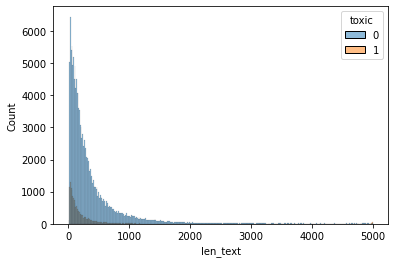

In [16]:
# распределенгие частот во всем датасете
sns.histplot(data=data, x='len_text',hue='toxic')

видно что длина текста не зависит от токсичности - в обоих классах частота равномерно снижается с увеличением количества символов.

Также видно длинный хвост

In [17]:
df[df['len_text'] > 2000]['toxic'].value_counts()

0    3681
1     368
Name: toxic, dtype: int64

<AxesSubplot:xlabel='len_text', ylabel='Count'>

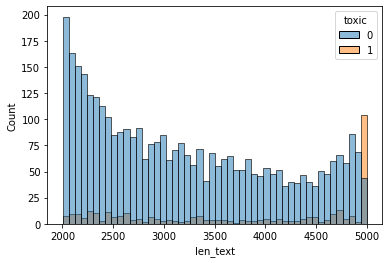

In [18]:
sns.histplot(data=df[df['len_text'] > 2000], x='len_text',hue='toxic',bins=50)

некоторые токсичные критики нежалеют слов - пока оставим их, может в их текстах окажутся ценные для обучения токены

##### Процент знаков пунктуации

возможно при написании токсичных сообщений люди не утруждаютсяебя расстановкой знаков препинания..

In [19]:
# создадим функцию 
import string

def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")), 3) * 100

In [20]:
df['punct%'] = df['text'].apply(count_punct)

<AxesSubplot:xlabel='punct%', ylabel='Count'>

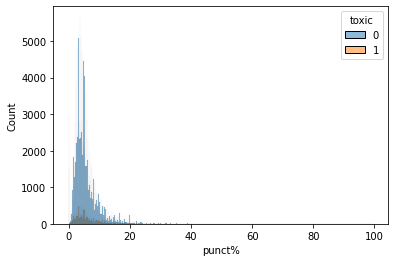

In [21]:
sns.histplot(data=df, x='punct%',hue='toxic')

на графике видно что особых различий в количестве знаков пунктуации нет, но интересно то что есть тексты с большим процентным соотношением 

#### Разделение на train/valid/test выборки

In [22]:
df_train, df_valid = train_test_split(df, test_size=0.4,
                                      random_state=42, stratify=df['toxic'])
#  stratify - баланс классов


df_valid, df_test = train_test_split(df_valid, test_size=0.4,
                                      random_state=42, stratify=df_valid['toxic'])


print(df_train.shape, df_valid.shape, df_test.shape)

(95742, 5) (38297, 5) (25532, 5)


#### Векторизация 

In [23]:
# создадим счётчик, указав в нём стоп-слова
count_tfidf = TfidfVectorizer(   max_features=100000, #  самых частых слов 
                                 min_df=3,  # не реже чем в 3 
                                 max_df=0.3,  # не больше чем в 30% 
                                 stop_words=stopwords
                                )

# count_tfidf_bigram = TfidfVectorizer(ngram_range=(2,2), max_features=10000)

In [24]:
# создадим модель 
model_lr = LogisticRegression(max_iter=200, class_weight='balanced', random_state=42)

# прогоним через ниё векторизированные тексты
for item in lemmatizers:
    # посчитаем TF-IDF для корпуса текстов
    tfidf_train = count_tfidf.fit_transform(df_train[item])
    tfidf_valid = count_tfidf.transform(df_valid[item])
    tfidf_test = count_tfidf.transform(df_test[item])

    #tfidf_train_bigram = count_tfidf_bigram.fit_transform(df_train[item])
    #tfidf_train_bigram = count_tfidf_bigram.transform(df_valid[item])
    
    
    
    # попытка собрать датафрейм с признаками но вешает ядро
#     X_train = pd.concat([df_train[['len_text','punct%']].reset_index(drop=True),
#                         pd.DataFrame(tfidf_train.toarray(), columns=count_tfidf.get_feature_names()),
#                         pd.DataFrame(tfidf_train_bigram.toarray(), columns=count_tfidf_bigram.get_feature_names())], 
#                         axis=1)
#     X_valid = pd.concat([df_valid[['len_text','punct%']].reset_index(drop=True),
#                         pd.DataFrame(tfidf_valid.toarray(), columns=count_tfidf.get_feature_names()),
#                         pd.DataFrame(tfidf_valid_bigram.toarray(), columns=count_tfidf_bigram.get_feature_names())],  
#                         axis=1)

    X_train = tfidf_train
    X_valid = tfidf_valid
    X_test = tfidf_test
    
    y_train = df_train['toxic']
    y_valid = df_valid['toxic']
    y_test = df_test['toxic']
    
    model_lr.fit(X_train, y_train)
    pred = model_lr.predict(X_valid)
    precision, recall, fscore, support = score( y_valid, pred, average='binary')
    print(item)
    print(f'Precision: {round(precision, 3)} / Recall: {round(recall, 3)} / F1-Score: {round(fscore,3)}')



wordnet
Precision: 0.652 / Recall: 0.859 / F1-Score: 0.742


Качество примерно одинаково. Текст лемматизированный spacy показал чуть луший результат - но скорость лемматизации того не стоит.


F-мера не дотягивает до нужной цифры, попробуем изменить порог чуствительности логистической регрессии


In [130]:
def get_best_threshold(X_valid, y_valid):
    THRESHOLD = 0
    step = 0.05
    best_score = 0
    y_logistic_prob = model_lr.predict_proba(X_valid)
    while THRESHOLD < 1:
        THRESHOLD += step
        pred = binarize(y_logistic_prob, THRESHOLD)[:,1]
        score =  f1_score( y_valid, pred)
        if score > best_score:
            best_score = score
            best_threshold = THRESHOLD
    print(f'наибольший f1: {round(best_score, 4)} при пороге: {round(best_threshold,3)}')

get_best_threshold(X_valid, y_valid)

наибольший f1: 0.7795 при пороге: 0.7


In [131]:
THRESHOLD = 0.7

# This probabilities would come from logistic_regression.predict_proba()
y_logistic_prob = model_lr.predict_proba(X_valid) 

pred = binarize(y_logistic_prob, THRESHOLD)[:,1]  #.ravel() #.reshape(-1, 1)
precision, recall, fscore, support = score( y_valid, pred, average='binary')
print(f'Precision: {round(precision, 3)} / Recall: {round(recall, 3)} / F1-Score: {round(fscore,3)}')

Precision: 0.809 / Recall: 0.752 / F1-Score: 0.78


Спомощью подбора порога чуствительности смогли получить макчимальнуй fмеру на валидационной выборке
но скорее всего это приведет к переобучению - и на тесте показатель будет ниже

#### LightGBM

Опробуем модель с градиентным бустингом. Для поиска лучших гиперпараметров воспользуюсь бибоиотекой optuna - использующая улучшенный алгоритмом случайного перебора параметров

In [ ]:

def run(trial: optuna.Trial):

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500, 50),
        'max_depth': trial.suggest_int('max_depth', 10, 50, 5),
        'num_leaves': trial.suggest_int('num_leaves', 100, 500, 50),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5, step=None, log=True),
        #'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt','dart', 'goss'])          
    }
    
    model_lgbm = LGBMClassifier(**params, boosting_type='gbdt', random_state=42)
    model_lgbm.fit(X_train, y_train)
    pred = model_lgbm.predict(X_valid)
    score = f1_score(y_valid, pred)
    return score


start = datetime.now()
study = optuna.create_study(direction='maximize')
study.optimize(run, n_trials=15)
print(datetime.now() - start)

[I 2022-06-04 06:13:09,173] A new study created in memory with name: no-name-10d9d7d2-99d9-4a45-9865-b44c0665847a
[I 2022-06-04 06:19:39,032] Trial 0 finished with value: 0.7602425676675048 and parameters: {'n_estimators': 500, 'max_depth': 15, 'num_leaves': 150, 'learning_rate': 0.0884420307251632}. Best is trial 0 with value: 0.7602425676675048.


In [ ]:
parametrs = study.best_trials[0].params
parametrs

In [87]:
# parametrs =  {'n_estimators': 200,
#  'max_depth': 35,
#  'num_leaves': 100,
#  'learning_rate': 0.18030310190165477}

Обучим модель на лучших параметрах 

In [ ]:
model_lgbm = LGBMClassifier(**parametrs, boosting_type='gbdt', random_state=42)
model_lgbm.fit(X_train, y_train)

In [132]:
pred = model_lgbm.predict(X_valid)

get_best_threshold(X_valid, y_valid)
precision, recall, fscore, support = score( y_valid, pred, average='binary')
print(f'Precision: {round(precision, 3)} / Recall: {round(recall, 3)} / F1-Score: {round(fscore,3)}')

наибольший f1: 0.7795 при пороге: 0.7
Precision: 0.887 / Recall: 0.676 / F1-Score: 0.767


Проведем финальное тестирование

In [134]:
model_lgbm = LGBMClassifier(**parametrs, boosting_type='gbdt', random_state=42)
model_lgbm.fit(X_train, y_train)
pred = model_lgbm.predict(X_test)

In [135]:
precision, recall, fscore, support = score( y_test, pred, average='binary')
print(f'Precision: {round(precision, 3)} / Recall: {round(recall, 3)} / F1-Score: {round(fscore,3)}')

Precision: 0.893 / Recall: 0.674 / F1-Score: 0.769


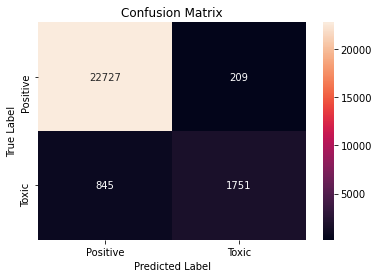

In [136]:
cm = confusion_matrix(y_test, pred)
class_label = ["Positive", "Toxic"]
df_cm = pd.DataFrame(cm, index=class_label, columns=class_label)
sns.heatmap(df_cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

LogisticRegression: ROC AUC=0.960


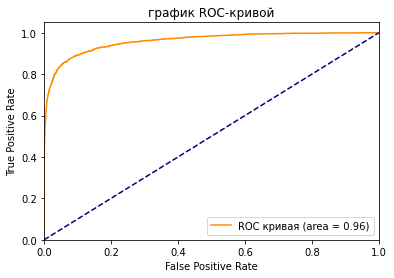

In [137]:
# получаем вероятности предказаний
probs = model_lgbm.predict_proba(X_test)
# сохраняем вероятности только для положительного исхода
probs = probs[:, 1]

# рассчитываем ROC AUC
model_auc = roc_auc_score(y_test, probs)
print('LogisticRegression: ROC AUC=%.3f' % (model_auc))

# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)

# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('график ROC-кривой')
plt.legend(loc="lower right")
plt.show()


ROC AUC выглядит как у хорошей модели классификации - но стоит понимать что у нас большой перекос в балансе классов тоесть если бы мы везде предсказали класс 0 то мы угадали бы в 90% случаях.

Сравню с классификатором "на дурочка".

In [121]:
model_dummy = DummyClassifier(strategy='stratified')
model_dummy.fit(tfidf_train, df_train['toxic'])
pred = model_dummy.predict(tfidf_valid)

precision, recall, fscore, train_support = score(df_valid['toxic'], pred,  average='binary')
print(f'Precision: {round(precision, 3)} / Recall: {round(recall, 3)} / F1-Score: {round(fscore,3)} ')

Precision: 0.101 / Recall: 0.1 / F1-Score: 0.101 


Проверку на адекватность модели похоже прошли.


In [ ]:
применим порог подобраный на валидационной выборке 

In [141]:
THRESHOLD = 0.7

y_logistic_prob = model_lgbm.predict_proba(X_test) 

pred = binarize(y_logistic_prob, THRESHOLD)[:,1]  #.ravel() #.reshape(-1, 1)
precision, recall, fscore, support = score( y_test, pred, average='binary')
print(f'Precision: {round(precision, 3)} / Recall: {round(recall, 3)} / F1-Score: {round(fscore,3)}')

Precision: 0.928 / Recall: 0.609 / F1-Score: 0.735


к сожалению Recall на тесте очень низок и потащил fмеру - порог чуствительности необходимо выбрать другой , но модель и сама справилась с задачей - по умолчанию порог у неё - 0.5

## Выводы

Похоже для достижения более лучших показателей качества не обойтись без эммбединга. Возможно тут помогло бы еще какой нибудь фитч инжиниринг .


Также в данных проблема с перекосом баланса классов который решается семплингом.

использование различных лемматизаторов на качество почти не влияет. но в связи с более быстрой работой алгоритма для лемматизации лучше использовать библеотеку pymystem3.

модельна с градиентным бустингом не смогла показать результат лучше логистической регрессии. возможео изза переобучения


бывшие в разработке куски кода

### с Bert

Решим задачу классификации применив векторные представления на базе BERT

In [ ]:
Предобработка текста

In [ ]:

# # инициализируем токенизатор со словарём
# tokenizer = transformers.BertTokenizer(
#     vocab_file='/datasets/ds_bert/vocab.txt')

# # преобразуем текст в номера токенов из словаря
# tokenized = data['text'].apply(
#     lambda x: tokenizer.encode(x, add_special_tokens=True)) # с добавлением  начала и конца токена

# # вычислим максимальную длину из векторов объектов
# max_len = 0
# for i in tokenized.values:
#     if len(i) > max_len:
#         max_len = len(i)

# # добавим "отступы" для выравнивания векторов        
# padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

# # создадим маску внимания для игнорирования "отступных" нулей
# attention_mask = np.where(padded != 0, 1, 0)

In [ ]:
# # инициализируем саму модель класса BertModel. Передадим ей файл с предобученной моделью и конфигурацией

# config = transformers.BertConfig.from_json_file(
#     '/datasets/ds_bert/bert_config.json')

# model = transformers.BertModel.from_pretrained(
#     '/datasets/ds_bert/rubert_model.bin', config=config)

In [ ]:
# # зададим размер батча
# batch_size = 100

# # сделаем цикл по батчам. Отображать прогресс будет функция notebook
# embeddings = []
# for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        
#         # преобразуем данные в формат тензоров
#         batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)])  
#         attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)]) 
        
#         # with torch.no_grad():  # ускорения вычисления
#         # чтобы получить эмбеддинги для батча, передадим модели данные и маску
#         batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
#         # преобразуем элементы методом numpy() к типу numpy.array
#         embeddings.append(batch_embeddings[0][:,0,:].numpy())

In [ ]:
# # соберём все эмбеддинги в матрицу признаков 
# features = np.concatenate(embeddings)
# target = data['positive']

# # разделим на тренировочную и валидационную выборки
# features_train, features_test, target_train, target_test = train_test_split(features, target, test_size = 0.5)
# print(features_train.shape, target_train.shape,features_test.shape, target_test.shape)

In [ ]:
# model_lr = LogisticRegression()
# score = cross_val_score(model_lr,features_train,target_train, cv=3, scoring='accuracy' )
# score.mean()

In [ ]:
# model_lr.fit(features_train, target_train)
# predict = model_lr.predict(features_test)
# accuracy_score(target_test,predict)